### SimCLR Self-Supervised Learning with Lightly

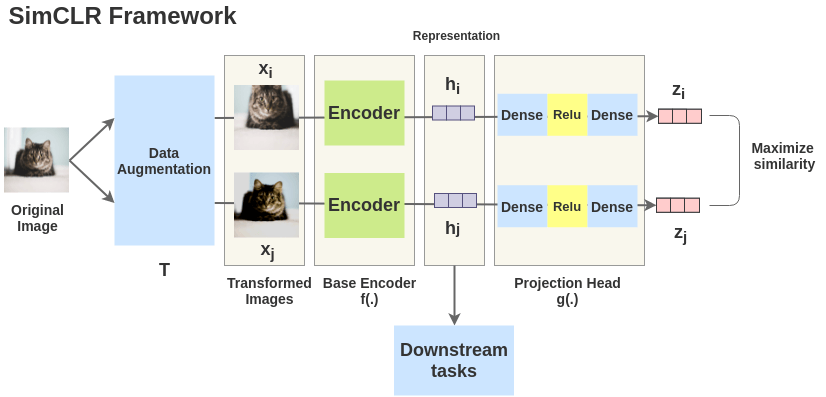

Importing Packages

In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

%matplotlib inline

Experiment Config

In [18]:
num_workers = 4
batch_size = 256
seed = 1
max_epochs = 20
input_size = 128
num_ftrs = 32

In [19]:
pl.seed_everything(seed)

Seed set to 1


1

### Download the dataset

In [4]:
#!git clone https://github.com/alexeygrigorev/clothing-dataset.git

In [20]:
path_to_data = "./clothing-dataset/images"

### Key Concepts:

Contrastive Learning:
SimCLR is based on contrastive learning, which learns by contrasting positive and negative examples. In SimCLR, two different augmented views of the same image are considered a positive pair, while views from different images are considered negative pairs. 

Data Augmentation:
SimCLR relies on strong data augmentation techniques to generate different views of the same image. Common augmentations include random cropping, color jittering, and Gaussian blur. 

Encoder Network:
An encoder network (like a ResNet) is used to map the augmented images into a latent space, producing high-dimensional representations. 

Projection Head:
A non-linear projection head (often a multi-layer perceptron) is used to map the encoder's output into a lower-dimensional space where the contrastive loss is applied. 

Contrastive Loss:
NT-Xent loss compares pairs of augmented images and penalizes similar views of different images.


### Data Augmentation

In [21]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

/home/mayur/Documents/git-repo-with-ads/Explore-Libraries/ssl-env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Create SimCLR

In [22]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

### Training

In [8]:
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mayur/Documents/git-repo-with-ads/Explore-Libraries/ssl-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mod

Epoch 19: 100%|██████████| 22/22 [00:09<00:00,  2.21it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:11<00:00,  1.99it/s, v_num=2]


### Visualization

In [23]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [24]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

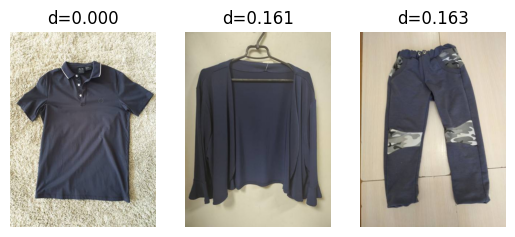

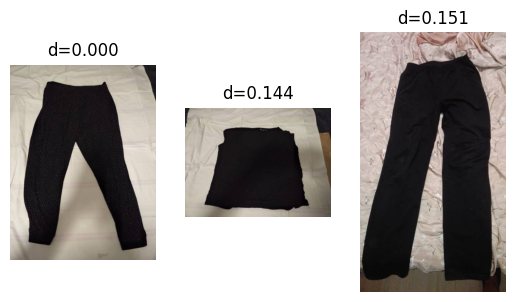

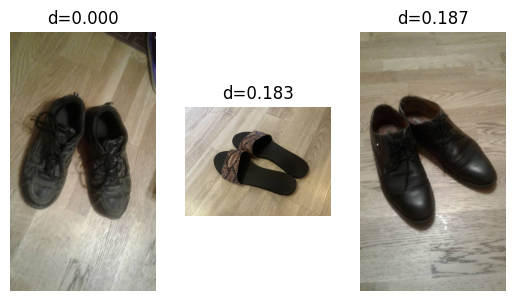

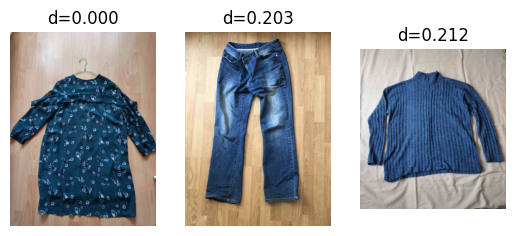

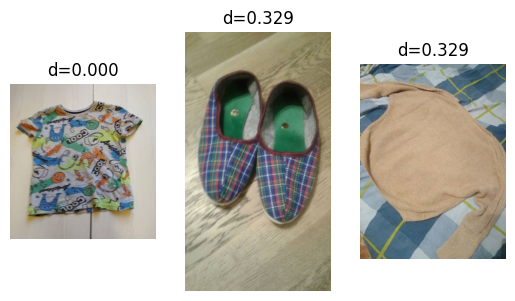

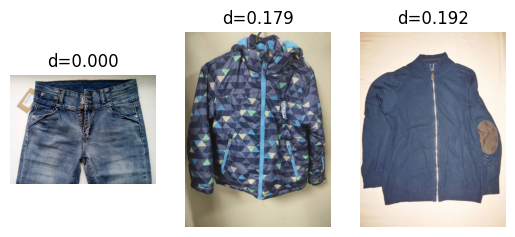

In [25]:
plot_knn_examples(embeddings, filenames)

**ColorJitter randomly change the brightness, contrast, saturation and hue of an image.**

In [12]:
# Set color jitter and gray scale probability to 0
new_transform = SimCLRTransform(
    input_size=input_size, vf_prob=0.5, rr_prob=0.5, cj_prob=0.0, random_gray_scale=0.0
)

# let's update the transform on the training dataset
dataset_train_simclr.transform = new_transform

# then train a new model
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)


/home/mayur/Documents/git-repo-with-ads/Explore-Libraries/ssl-env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M | train
1 | projection_head | SimCLRProjectionHead | 328 K  | train
2 | cr

Epoch 19: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, v_num=3]


In [14]:
# and generate again embeddings from the test set
model.eval()
embeddings_cj, filenames = generate_embeddings(model, dataloader_test)

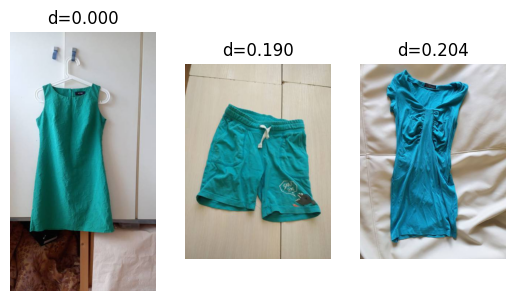

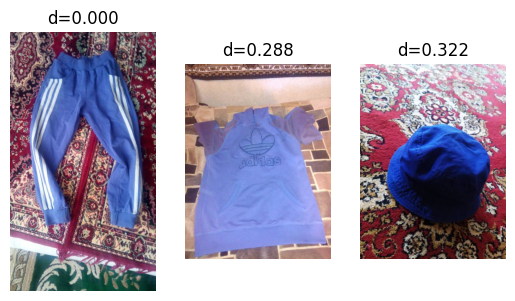

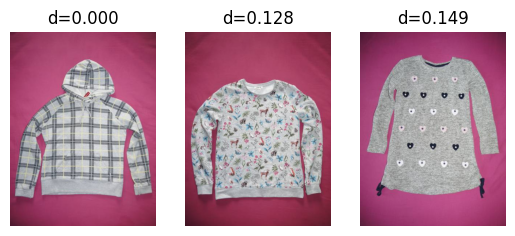

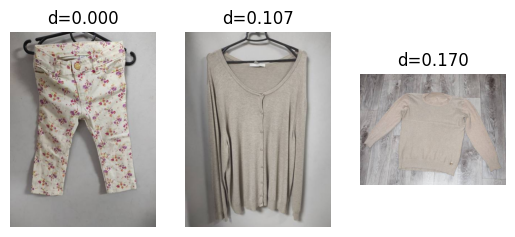

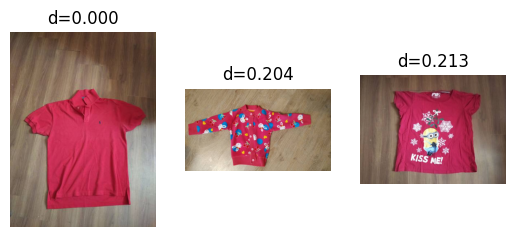

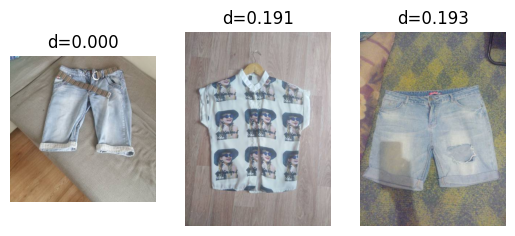

In [15]:
plot_knn_examples(embeddings_cj, filenames)